In [1]:
import pygrib, time, os, sys, scipy
import numpy as np
import cartopy as ct
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
from datetime import datetime, timedelta

#### Global variables

In [2]:
# initial tracking parameters
top_lat = 50.
right_lon = -40.

# lat/lon bounding box for US east coast
usne_N = 45 # deg lat
usne_S = 33 # deg lat
usne_E = -70 # deg lon
usne_W = -80 # deg lon

# timestepping parameters
dt = 6 # h

# other settings
data_label_1 = ['av_tpr_h_500 (m^3/h)', 'av_tpr_h_750 (m^3/h)', 'av_tpr_h_1000 (m^3/h)']
std_label_1 = ['std_tpr_h_500 (m^3/h)', 'std_tpr_h_750 (m^3/h)', 'std_tpr_h_1000 (m^3/h)']
reg_label_1 = [1, 2, 3]
pan_label_1 = ["A", "B", "C"]
plot_titles_1 = ['Mean Hourly Precipitation, 500 km radius ($m^{3}$/h)', 'Mean Hourly Precipitation, 750 km radius ($m^{3}$/h)', 'Mean Hourly Precipitation, 1000 km radius ($m^{3}$/h)']

#### Functions - loading storm track output

In [3]:
# takes storm tracking dataframe and drops storms that don't reach a min SLP
def SLP_filter(df_out, minSLP):
    df_out = df_out.drop(df_out[df_out['min_p_h (Pa)'] > minSLP].index)
    df_out = df_out.reset_index(drop=True)
    return df_out

In [4]:
# reads CSV file of storm track output into a dataframe
def read_track_csv(year):
    # path_base = r"C:\Users\kevin\Desktop\Research EESC\ERA5 reanalysis data"
    path_base = r"/.../noreasters"
    return pd.read_csv(path_base + '/' + str(year) + '_tracks_final.csv', usecols=np.arange(1, 31))

In [5]:
# helper function
def read_list(l):
    return [float(n) for n in l[1:-1].split()]

In [6]:
# read storm tracking output into a dataframe, drop storms that do not reach min SLP
def read_years_SLP(years, minSLP):
    all_df = []
    for year in years:
        all_df.append(SLP_filter(read_track_csv(year), minSLP))
    return all_df

In [7]:
# experimenting with different storm radii: 500 km, 750 km, and 1000 km
# max_w_h means maximum wind speed at each 1-h timestep, 500 km radius
# max_w_6_750 is 6-h timesteps, 750 km radius
def yr_max_w_6(dfi):
    max_w_hs = dfi['max_w_h (m/s)']
    max_w_6s = []
    max_w_hs_750 = dfi['max_w_h_750 (m/s)']
    max_w_6s_750 = []
    max_w_hs_1000 = dfi['max_w_h_1000 (m/s)']
    max_w_6s_1000 = []
    for i in range(len(dfi)):
        li = read_list(max_w_hs[i])[::6]
        max_w_6s.append(np.max(li))
        li_750 = read_list(max_w_hs_750[i])[::6]
        max_w_6s_750.append(np.max(li_750))
        li_1000 = read_list(max_w_hs_1000[i])[::6]
        max_w_6s_1000.append(np.max(li_1000))
    dfi['max_w_6_500 (m/s)'] = max_w_6s
    dfi['max_w_6_750 (m/s)'] = max_w_6s_750
    dfi['max_w_6_1000 (m/s)'] = max_w_6s_1000
    return dfi

#### Mean hourly precipitation trends over time

In [8]:
# given a dataframe with the columns specified below, calculates averages
# and stdevs for these columns and returns a row with these values
def row_av(df, ti):
    cols = ['tpr_h_500 (m^3/h)', 'tpr_h_750 (m^3/h)', 'tpr_h_1000 (m^3/h)']
    newrow = [ti, len(df)]
    for i in range(len(cols)):
        av = np.mean(df[cols[i]])
        std = np.std(df[cols[i]])
        newrow.append(av)
        newrow.append(std)
    return newrow

In [9]:
newcols = ['year', 'freq', 'av_tpr_h_500 (m^3/h)', 'std_tpr_h_500 (m^3/h)', 'av_tpr_h_750 (m^3/h)', 'std_tpr_h_750 (m^3/h)', 'av_tpr_h_1000 (m^3/h)', 'std_tpr_h_1000 (m^3/h)']
param_cols = ['freq', 'av_tpr_h_500 (m^3/h)', 'av_tpr_h_750 (m^3/h)', 'av_tpr_h_1000 (m^3/h)']

In [10]:
# given a list of dataframes for a range of years, calculates averages and stdevs for each year
def years_stats(dfs, years):
    stats = []
    for i in range(len(years)):
        stats.append(row_av(dfs[i], years[i]))
    return pd.DataFrame(stats, columns=newcols)

In [11]:
# given a time series dataframe, correlate the other parameters with time
def time_regress(df_time, t_period, althyp):
    results_arr = []
    df1 = df_time[df_time['freq'] > 0]
    for param in param_cols:
        resultsi = scipy.stats.linregress(df1[t_period], df1[param], alternative=althyp)
        results_arr.append(resultsi)
    return results_arr

In [12]:
allyrs = np.arange(1940, 2025)
dfs = read_years_SLP(allyrs, 98000)
dfs_6 = []
for i in range(len(allyrs)):
    dfs_6.append(yr_max_w_6(dfs[i]))

# calculate mean hourly precipitation from storm tracking output for 3 radii
for dfi in dfs:
    dfi['tpr_h_500 (m^3/h)'] = dfi['total_precip (m^3)']/dfi['lifetime (h)']
    dfi['tpr_h_750 (m^3/h)'] = dfi['total_precip_750 (m^3)']/dfi['lifetime (h)']
    dfi['tpr_h_1000 (m^3/h)'] = dfi['total_precip_1000 (m^3)']/dfi['lifetime (h)']

In [13]:
dfs_pr_stats = years_stats(dfs, allyrs)
year_pr_reg = time_regress(dfs_pr_stats, 'year', 'greater')

### Check autocorrelation

Text(0, 0.5, 'Correlation')

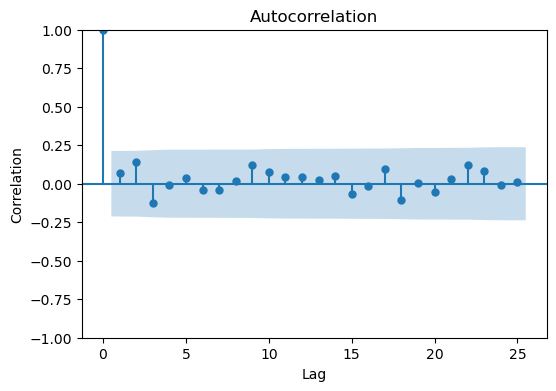

In [14]:
slope, intercept, _, _, _ = stats.linregress(allyrs, dfs_pr_stats[data_label_1[1]])
av_tpr_detrended = dfs_pr_stats[data_label_1[1]] - (slope * allyrs + intercept)

fig, ax = plt.subplots(figsize=(6, 4))
# sm.graphics.tsa.plot_acf(dfs_pr_stats[data_label_1[1]], lags=25, ax=ax)
sm.graphics.tsa.plot_acf(av_tpr_detrended, lags=25, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Correlation')

# Fig5: Mean hourly precipitation for effective storm radius of 750 km

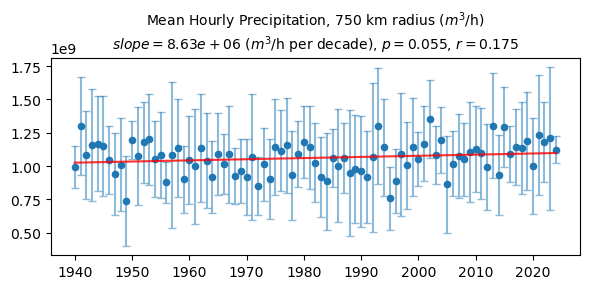

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)

ax.errorbar(dfs_pr_stats['year'], dfs_pr_stats[data_label_1[1]], dfs_pr_stats[std_label_1[1]], fmt='none', capsize=3, alpha=0.5)
ax.scatter(dfs_pr_stats['year'], dfs_pr_stats[data_label_1[1]], s=20)
ax.plot(dfs_pr_stats['year'], year_pr_reg[reg_label_1[1]].intercept + year_pr_reg[reg_label_1[1]].slope*dfs_pr_stats['year'], 'r', linewidth=1.5, alpha=0.8)
ax.set_title(f'{plot_titles_1[1]}\n$slope={year_pr_reg[reg_label_1[1]].slope* 10:.2e}$ ($m^{3}$/h per decade), $p={year_pr_reg[reg_label_1[1]].pvalue:.3f}$, $r={year_pr_reg[reg_label_1[1]].rvalue:.3f}$', size=10)
ax.set_xticks(np.arange(1940, 2030, 10))

# # Save plot
# plt.savefig('Fig5_750_mean_hourly_precipitation.pdf', format='pdf', dpi=1000, bbox_inches='tight') 

# FigS9: Mean hourly precipitation for effective storm radii of 500 km, 750 km, and 1000 km

499495.1382434797
862586.7856368743
1176932.143637607


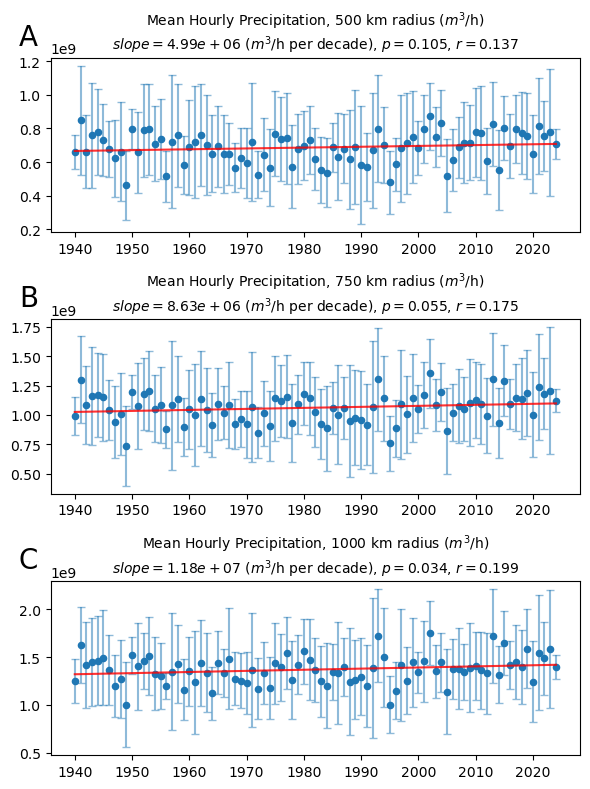

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8), tight_layout=True)

for i in range(3):
    ax[i].errorbar(dfs_pr_stats['year'], dfs_pr_stats[data_label_1[i]], dfs_pr_stats[std_label_1[i]], fmt='none', capsize=3, alpha=0.5)
    ax[i].scatter(dfs_pr_stats['year'], dfs_pr_stats[data_label_1[i]], s=20)
    ax[i].plot(dfs_pr_stats['year'], year_pr_reg[reg_label_1[i]].intercept + year_pr_reg[reg_label_1[i]].slope*dfs_pr_stats['year'], 'r', linewidth=1.5, alpha=0.8)
    ax[i].set_title(f'{plot_titles_1[i]}\n$slope={year_pr_reg[reg_label_1[i]].slope* 10:.2e}$ ($m^{3}$/h per decade), $p={year_pr_reg[reg_label_1[i]].pvalue:.3f}$, $r={year_pr_reg[reg_label_1[i]].rvalue:.3f}$', size=10)
    print(year_pr_reg[reg_label_1[i]].slope)
    ax[i].set_xticks(np.arange(1940, 2030, 10))
    ax[i].text(-0.06, 1.2, pan_label_1[i], fontsize=20, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes)

# # Save plot
# plt.savefig('FigS9_all_mean_hourly_precipitation.pdf', format='pdf', dpi=1000, bbox_inches='tight') 